Lab 6 – Face Detection and Recognition


Part 1: Face Detection với Haar Cascade


In [1]:
# Cell 1: Import thư viện cần thiết
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Đảm bảo hiển thị ảnh ngay trong notebook
%matplotlib inline

print("OpenCV version:", cv2.__version__)


OpenCV version: 4.11.0


In [ ]:
# Cell 2: Load classifier Haar Cascade (OpenCV đã kèm sẵn trong thư mục data)
# Bạn cần có đường dẫn tới file xml (Haar Cascade) – nếu cài OpenCV tiêu chuẩn, nó nằm trong thư mục
#    <env>/lib/python3.x/site-packages/cv2/data/haarcascade_frontalface_default.xml

# Cách lấy đường dẫn gọn:
haar_face_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
# Nếu muốn detect thêm mắt, mũi, miệng, bạn có thể load thêm:
haar_eye_path = cv2.data.haarcascades + "haarcascade_eye.xml"
# (có thể còn các file khác như nose hoặc smile, tuỳ OpenCV version)

# Khởi tạo cascade classifier
face_cascade = cv2.CascadeClassifier(haar_face_path)
eye_cascade = cv2.CascadeClassifier(haar_eye_path)

# Kiểm tra xem file có load đúng không
if face_cascade.empty():
    raise IOError("Không load được Haar Cascade. Kiểm tra lại đường dẫn!")

print("Haar Cascade đã sẵn sàng để detect face.")


Haar Cascade đã sẵn sàng để detect face.


Phát hiện được 1 face(s).


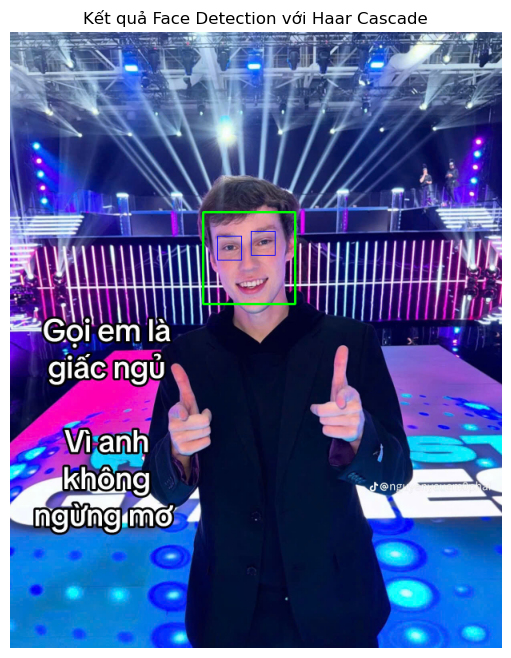

In [ ]:
# Cell 3: Đọc ảnh test (có mặt người) rồi detect face
# Sửa thành đường dẫn file của bạn
path_test = r"E:\MSE\HomeWork\Ky 2\IVP501\Test\IMG\6a92c8df69e5dcbb85f43.jpg"
img_bgr = cv2.imread(path_test)  # BGR
if img_bgr is None:
    raise FileNotFoundError("Không tìm thấy ảnh , kiểm tra lại đường dẫn!")

# Resize (nếu ảnh quá lớn, để dễ show) – tuỳ ý
scale = 0.5  # giảm 50%
img_bgr = cv2.resize(img_bgr, (0, 0), fx=scale, fy=scale)

# Copy giữ nguyên bản gốc để vẽ bounding box lên
display_img = img_bgr.copy()

# Chuyển sang grayscale vì Haar Cascade yêu cầu gray image
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# Detect faces: scaleFactor=1.1, minNeighbors=5 là tham số thường dùng
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

# In ra số face detect được
print(f"Phát hiện được {len(faces)} face(s).")

# Vẽ bounding box quanh mỗi face
for (x, y, w, h) in faces:
    cv2.rectangle(display_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    # Optionally: detect mắt bên trong vùng face
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = display_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(
        roi_gray, scaleFactor=1.1, minNeighbors=5)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (255, 0, 0), 1)

# Show kết quả (chuyển BGR→RGB để matplotlib hiển thị đúng màu)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
plt.title("Kết quả Face Detection với Haar Cascade")
plt.axis("off")
plt.show()


In [ ]:
# Cell 4: Face Detection real-time từ webcam
# Lưu ý: chỉ chạy trong môi trường Jupyter hỗ trợ mở webcam, hoặc bạn có thể copy ra script .py và chạy trực tiếp.

cap = cv2.VideoCapture(0)  # Mặc định webcam index 0
if not cap.isOpened():
    raise RuntimeError("Không mở được webcam. Kiểm tra camera kết nối!")

print("Nhấn 'q' để thoát.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame (tuỳ ý, để nhẹ)
    frame = cv2.resize(frame, None, fx=0.6, fy=0.6)

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces_live = face_cascade.detectMultiScale(
        gray_frame, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces_live:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Show frame real-time (chuyển BGR→RGB cho đúng màu trên matplotlib)
    # Tuy nhiên, Jupyter không render real-time mượt, bạn có thể xài cv2.imshow khi chạy ngoài script.
    cv2.imshow("Live Face Detection", frame)

    # Nhấn 'q' để thoát loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Nhấn 'q' để thoát.


Part 2: Face Recognition bằng Eigenfaces


In [ ]:
# Cell 5: Load toàn bộ dataset vào bộ nhớ
import os

# Đường dẫn tới dataset (folder cha chứa nhiều folder con)
dataset_path = "face_dataset"  # Sửa thành thư mục thật của bạn

# Danh sách folder trong dataset_path, sorted để consistent
person_folders = sorted([d for d in os.listdir(r"E:\MSE\HomeWork\Ky 2\IVP501\Test\Lab 6\face_dataset")
                         if os.path.isdir(os.path.join(r"E:\MSE\HomeWork\Ky 2\IVP501\Test\Lab 6\face_dataset", d))])

print("Danh sách person:", person_folders)

# Mảng chứa ảnh và label
images_list = []
labels_list = []

# Kích thước chuẩn cho face image (crop/resize về)
# bạn có thể chọn 80x80, 128x128, ... nhưng nhớ quy chuẩn
face_size = (100, 100)

for person in person_folders:
    folder_path = os.path.join(
        r"E:\MSE\HomeWork\Ky 2\IVP501\Test\Lab 6\face_dataset", person)
    # Lặp qua tất cả file ảnh trong folder (giả sử .jpg hoặc .png)
    for filename in os.listdir(folder_path):
        if not (filename.lower().endswith(".jpg") or filename.lower().endswith(".png")):
            continue
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # load grayscale
        if img is None:
            print(f"Không load được {img_path}, bỏ qua.")
            continue
        # Resize về face_size
        img_resized = cv2.resize(img, face_size)
        images_list.append(img_resized)
        labels_list.append(person)

num_images = len(images_list)
print(
    f"Đã load tổng cộng {num_images} ảnh, thuộc {len(person_folders)} người.")


Danh sách person: ['Binh', 'cr7', 'm10']
Đã load tổng cộng 16 ảnh, thuộc 3 người.


In [ ]:
# Cell 6: Build data matrix X và tính mean_face
h, w = face_size
num_pixels = h * w

# Tạo ma trận X: shape = (num_pixels, num_images)
X = np.zeros((num_pixels, num_images), dtype=np.float32)

for i, img in enumerate(images_list):
    flat = img.flatten().astype(np.float32)  # shape = (num_pixels,)
    X[:, i] = flat

# Tính mean face (vector) - shape (num_pixels, 1)
mean_face = np.mean(X, axis=1).reshape(-1, 1)  # cột

# Subtract mean: Phi = X - mean_face (broadcasting)
Phi = X - mean_face  # shape vẫn (num_pixels, num_images)

print("Mean face shape:", mean_face.shape)
print("Phi shape (X - mean):", Phi.shape)


Mean face shape: (10000, 1)
Phi shape (X - mean): (10000, 16)


In [ ]:
# Cell 7: Tính ma trận L = Phi^T Phi và eigen decomposition
# L sẽ có shape (num_images, num_images)
L = np.dot(Phi.T, Phi)  # shape = (num_images, num_images)

# Tính eigenvalues và eigenvectors của L
# Vì L là đối xứng, ta dùng np.linalg.eigh để lấy eigenvalues sắp xếp tăng dần
eigenvalues, eigenvectors = np.linalg.eigh(L)

# np.linalg.eigh trả về eigenvalues (từ bé → lớn), eigenvectors tương ứng
# Ta muốn sắp xếp ngược lại để có các eigenvalues lớn nhất trước
idx_desc = np.argsort(-eigenvalues)
eigenvalues = eigenvalues[idx_desc]
eigenvectors = eigenvectors[:, idx_desc]

print("Top 5 eigenvalues (lớn nhất):", eigenvalues[:5])

# Loại bỏ eigenvalues (hoặc eigenvectors) quá bé (gần 0) vì no information
# Chọn k eigenfaces (ví dụ k = số người × 2, hoặc k = 50, hoặc tự chọn)
k = min(50, num_images)  # bạn có thể chỉnh k khác
eigenvalues_k = eigenvalues[:k]
eigenvectors_k = eigenvectors[:, :k]  # shape = (num_images, k)

# Tính eigenfaces (u_i) ‒ mỗi u_i có shape = (num_pixels,)
eigenfaces = np.zeros((num_pixels, k), dtype=np.float32)

for i in range(k):
    v_i = eigenvectors_k[:, i].reshape(-1, 1)  # shape = (num_images, 1)
    # shape = (num_pixels, 1)
    u_i = np.dot(Phi, v_i) / np.sqrt(eigenvalues_k[i] + 1e-8)
    # Chuẩn hóa L2
    norm = np.linalg.norm(u_i)
    if norm > 0:
        u_i = u_i / norm
    eigenfaces[:, i] = u_i.flatten()

print(f"Đã tính xong {k} eigenfaces.")


Top 5 eigenvalues (lớn nhất): [1.95813120e+08 1.22334504e+08 5.92334840e+07 4.35347680e+07
 3.97736240e+07]
Đã tính xong 16 eigenfaces.


C:\Users\Admin\AppData\Local\Temp\ipykernel_21476\2859831319.py:28: RuntimeWarning: invalid value encountered in sqrt
  u_i = np.dot(Phi, v_i) / np.sqrt(eigenvalues_k[i] + 1e-8)  # shape = (num_pixels, 1)


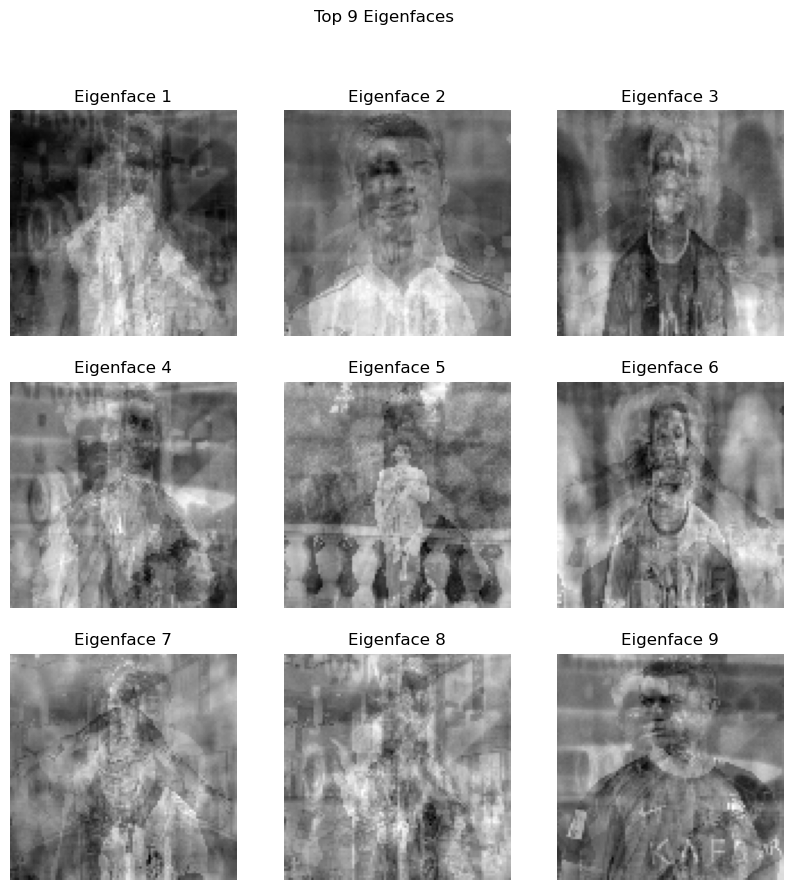

In [ ]:
# Cell 8: Hiển thị 9 eigenfaces (reshape về (h, w))
plt.figure(figsize=(10, 10))
for i in range(min(9, k)):
    ef = eigenfaces[:, i].reshape(h, w)
    plt.subplot(3, 3, i+1)
    plt.imshow(ef, cmap='gray')
    plt.title(f"Eigenface {i+1}")
    plt.axis("off")
plt.suptitle("Top 9 Eigenfaces")
plt.show()


In [ ]:
# Cell 9: Tạo weights_train (ma trận shape (k, num_images)) và labels, đồng thời lưu thành list
U = eigenfaces  # shape (num_pixels, k)

# Weights_train: columns là weights của từng ảnh train
weights_train = np.dot(U.T, Phi)  # shape = (k, num_images)

# weights_train[:, i] là weight vector (độ k) của ảnh thứ i
print("weights_train shape:", weights_train.shape)

# Đổi labels_list (strings) thành labels index (int) hoặc để nguyên dạng string
labels_train = labels_list[:]  # dạng list of strings length = num_images

# In thử 5 weights đầu tiên + label
for i in range(min(5, num_images)):
    print(f"Ảnh {i} ({labels_train[i]}) → weights[:5] =", weights_train[:5, i])


weights_train shape: (16, 16)
Ảnh 0 (Binh) → weights[:5] = [-5677.807    1608.6919   1362.8395    353.608     455.12677]
Ảnh 1 (Binh) → weights[:5] = [-4281.1074  -2435.7595    317.81552 -3601.8828   2154.437  ]
Ảnh 2 (Binh) → weights[:5] = [2686.8528 1896.8914 2190.4875 1910.6771 4334.228 ]
Ảnh 3 (cr7) → weights[:5] = [  835.16174  -601.1602  -1825.5786   1112.0221   -171.9954 ]
Ảnh 4 (cr7) → weights[:5] = [ 4453.275   1009.8162   675.7271 -1876.0154 -2873.5688]


In [ ]:
# Cell 10: Định nghĩa hàm để chuẩn bị 1 ảnh test (crop+resize) rồi project → weight
def compute_weight_for_face(face_img_gray):
    """
    Input: face_img_gray: ảnh grayscale đã crop region face (bất cứ kích thước)
    Output: weight: numpy array shape (k, ) – trọng số trên từng eigenface
    """
    # Resize về face_size (h, w)
    resized = cv2.resize(face_img_gray, face_size).astype(np.float32)
    flat = resized.flatten().reshape(-1, 1)  # shape (num_pixels,1)
    phi = flat - mean_face  # subtract mean
    weight = np.dot(U.T, phi)  # shape (k,1)
    return weight.flatten()   # trả về 1D array (k,)

# Hàm so sánh weight_test với tất cả weight_train, trả về:
#    best_label: nhãn (tên người) có khoảng cách nhỏ nhất
#    best_dist: khoảng cách nhỏ nhất đó


def recognize_face(weight_test, weights_train, labels_train):
    """
    Input:
      - weight_test: numpy array shape (k,)
      - weights_train: numpy array shape (k, num_images)
      - labels_train: list length = num_images (chuỗi tên người)
    Output:
      - best_label: tên người (string) có khoảng cách nhỏ nhất
      - best_dist: khoảng cách Euclid nhỏ nhất (float)
    """
    # Tính distance đến tất cả ảnh train
    # Cách 1 (vòng for):
    #    dists = [np.linalg.norm(weight_test - weights_train[:, i]) for i in range(num_images)]
    # Cách 2 (vectorized):
    # shape = (k, num_images)
    diffs = weights_train - weight_test.reshape(-1, 1)
    dists = np.linalg.norm(diffs, axis=0)              # shape = (num_images,)
    idx_min = np.argmin(dists)
    return labels_train[idx_min], dists[idx_min]


Phát hiện 4 face(s) trên ảnh test.


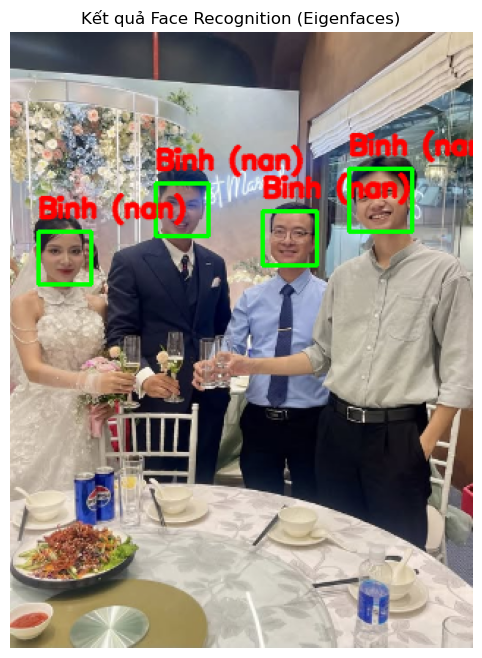

In [ ]:
# Cell 11: Kết hợp Face Detection & Recognition trên ảnh test
# Ảnh test có thể chứa nhiều người
path_test2 = r"E:\MSE\HomeWork\Ky 2\IVP501\Test\Lab 6\face_dataset\Binh\495294128_3058440080981222_5979983688375374564_n.jpg"
img_bgr2 = cv2.imread(path_test2)
if img_bgr2 is None:
    raise FileNotFoundError("Không tìm thấy anh test, kiểm tra lại đường dẫn!")

# Resize cho dễ quan sát (tuỳ ý)
scale = 0.6
img_bgr2 = cv2.resize(img_bgr2, None, fx=scale, fy=scale)

# Copy để vẽ bounding box + label
output_img = img_bgr2.copy()

# Grayscale để detect face
gray2 = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2GRAY)

# Detect faces (nếu muốn chính xác, bạn có thể thử minSize=(50,50) hoặc tune params)
faces2 = face_cascade.detectMultiScale(gray2, scaleFactor=1.1, minNeighbors=5)

print(f"Phát hiện {len(faces2)} face(s) trên ảnh test.")

for (x, y, w, h) in faces2:
    # Crop face region (trong grayscale)
    face_roi_gray = gray2[y:y+h, x:x+w]

    # Tính weight + nhận diện
    w_test = compute_weight_for_face(face_roi_gray)  # shape (k,)
    label_pred, dist_pred = recognize_face(w_test, weights_train, labels_train)

    # Vẽ bounding box + label + distance lên ảnh output
    # Màu xanh lá cho face, red cho text
    cv2.rectangle(output_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    text = f"{label_pred} ({dist_pred:.1f})"
    cv2.putText(output_img, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                0.6, (0, 0, 255), 2, cv2.LINE_AA)

# Show ảnh kết quả
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title("Kết quả Face Recognition (Eigenfaces)")
plt.axis("off")
plt.show()


In [ ]:
# Cell 12: Face Recognition live (webcam)
cap2 = cv2.VideoCapture(0)
if not cap2.isOpened():
    raise RuntimeError("Không mở được webcam.")

print("Nhấn 'q' để thoát.")

while True:
    ret, frame = cap2.read()
    if not ret:
        break

    frame = cv2.resize(frame, None, fx=0.6, fy=0.6)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces_live2 = face_cascade.detectMultiScale(
        gray_frame, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces_live2:
        # Crop face, compute weight + label
        face_roi = gray_frame[y:y+h, x:x+w]
        w_t = compute_weight_for_face(face_roi)
        label_t, dist_t = recognize_face(w_t, weights_train, labels_train)
        # Nếu khoảng cách > threshold, ta gọi “Unknown”
        thresh = 1000  # bạn tự điều chỉnh tuỳ dataset
        if dist_t > thresh:
            label_show = "Unknown"
        else:
            label_show = label_t
        # Vẽ bounding box + text
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        txt = f"{label_show}({dist_t:.1f})"
        cv2.putText(frame, txt, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 0, 255), 2, cv2.LINE_AA)

    cv2.imshow("Live Face Recognition (Eigenfaces)", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap2.release()
cv2.destroyAllWindows()


Nhấn 'q' để thoát.
